# 3. Кластеризация по метрике DTW

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 50)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm
from tqdm import tqdm_notebook

import math

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KDTree
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

from tslearn.metrics import cdist_dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import requests
import apimoex

### Импорт пользовательской библиотеки

In [ ]:
%load_ext autoreload
%autoreload 2

import sys

# setting path
sys.path.append('..')

# importing
from my_lib import *

In [4]:
def ts_first_view(df):
    ticker = df['SECID'][0]
    print(f'####################################################################')
    print(f'_________________________{ticker}___________________________________')
    print(f'####################################################################')
    display(df.head(3))
    display(df.tail(3))
    plot_data(df['CLOSE'], title=f'График цены {ticker}')
    
    plot_timeStamps(df['CLOSE'])

## 3.1 Подготовка данных

Зарузим наши отобранные данные

In [32]:
df_price_history = pd.read_pickle('../data/frames/df_selected.pkl')
df_price_history.head()

,IMOEX,YNDX,AGRO,ALRS,VTBR,BSPB,AFKS,AFLT,GAZP,GMKN,LSRG,MVID,MAGN,MTLR,MTLRP,MTSS,MOEX,LKOH,NLMK,PIKK,PLZL,RTKM,RTKMP,SBER,SBERP,CHMF,SELG,TGKA,TRNFP,HYDR,FEES,PHOR,MSNG,NVTK,ROSN,TATN,TATNP
TRADEDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-05,1435.66,1079.0,280.0,60.38,0.06750,24.60,12.25,33.21,133.95,8590.0,473.0,135.5,11.279,24.97,16.60,174.70,60.40,2295.0,66.285,191.7,1000.5,91.44,57.95,56.37,38.59,522.00,4.595,0.004840,130100.0,0.5656,0.04713,1784.0,0.6520,455.5,196.75,238.00,134.7
2015-01-06,1480.73,1092.0,310.0,61.28,0.06666,25.60,12.37,33.07,138.92,9101.0,473.0,146.0,11.550,25.30,17.29,179.90,61.90,2345.0,66.700,198.9,1047.0,95.28,58.11,58.28,39.50,556.90,4.500,0.004955,142990.0,0.5684,0.04850,1855.0,0.6625,476.7,200.30,228.75,135.3
2015-01-08,1547.39,1094.0,335.0,60.20,0.06741,26.50,12.60,35.17,146.46,9550.0,480.0,148.5,12.350,26.40,17.84,190.05,61.90,2572.0,67.410,191.2,1060.0,90.10,57.30,65.70,43.75,542.70,4.595,0.005000,130000.0,0.5772,0.05030,1776.0,0.6860,483.0,214.95,245.00,136.0
2015-01-09,1515.37,1098.0,306.0,61.91,0.06531,26.15,12.61,34.00,141.70,9740.0,489.0,145.9,12.100,26.50,17.67,195.00,60.14,2461.0,67.900,192.7,1050.0,89.03,57.30,63.10,42.90,548.55,4.555,0.004880,120820.0,0.5498,0.04897,1798.0,0.6860,475.1,206.60,234.05,134.5
2015-01-12,1513.22,1113.0,303.0,63.00,0.06353,25.70,12.13,34.45,140.22,9839.0,484.0,141.7,11.893,26.40,17.79,193.00,59.59,2477.0,70.120,188.0,1020.0,88.80,56.50,62.90,42.41,558.45,4.650,0.004800,128000.0,0.5451,0.04955,1795.0,0.6825,470.7,204.00,228.25,133.3


Перейдем к месячному шагу

In [34]:
df_price_history = change_timestamp(df_price_history, by='M')
df_price_history.head()

,IMOEX,YNDX,AGRO,ALRS,VTBR,BSPB,AFKS,AFLT,GAZP,GMKN,LSRG,MVID,MAGN,MTLR,MTLRP,MTSS,MOEX,LKOH,NLMK,PIKK,PLZL,RTKM,RTKMP,SBER,SBERP,CHMF,SELG,TGKA,TRNFP,HYDR,FEES,PHOR,MSNG,NVTK,ROSN,TATN,TATNP
2015-01-31,1647.69,1075.0,335.00,78.49,0.06894,26.10,13.33,38.25,143.82,11610.0,471.0,139.6,13.134,44.85,34.19,217.85,70.0,2789.9,91.995,189.7,1049.5,86.61,55.99,61.50,43.84,642.35,3.920,0.004320,141900.0,0.5251,0.04982,2291.0,0.6450,460.0,229.35,270.15,157.7
2015-02-28,1758.97,1016.0,375.00,68.50,0.06800,33.25,18.32,39.19,152.95,11182.0,589.0,166.3,14.600,82.27,58.40,249.00,76.9,2981.2,81.100,195.0,1110.0,91.00,61.10,75.91,53.70,682.00,4.615,0.004875,138000.0,0.6448,0.07535,2109.0,0.7580,503.7,265.85,316.00,168.6
2015-03-31,1626.18,893.0,349.95,72.00,0.06000,31.55,17.90,34.00,138.90,10399.0,665.0,193.0,14.990,74.30,50.76,247.00,69.0,2705.0,77.615,193.0,1016.5,79.00,58.00,62.88,45.63,658.00,4.380,0.004110,124500.0,0.5265,0.06588,2011.0,0.7175,432.0,252.15,287.00,165.7
2015-04-30,1688.34,1001.0,454.95,68.39,0.06550,36.95,15.96,38.15,153.50,9640.0,613.0,208.0,15.120,64.30,47.29,265.00,77.0,2645.6,68.280,192.0,1545.0,79.25,58.76,76.90,50.00,578.55,4.095,0.004540,121320.0,0.5985,0.07100,2039.0,0.9985,494.0,256.50,292.35,167.0
2015-05-31,1609.19,941.0,448.00,63.25,0.08025,39.85,16.90,41.10,139.00,9005.0,616.0,202.0,14.705,65.25,45.00,243.00,72.0,2461.3,73.000,183.1,1575.0,80.95,57.73,73.50,48.25,608.40,4.090,0.005105,123450.0,0.5873,0.06508,2001.0,0.9345,522.5,234.00,280.20,155.0


Перейдем по каждому тикеру к графику доходности относительно значения на начало отсчета - '2015-01-31'.

In [35]:
# Переходим к приросту относительно базового, в %
df_percent_last2base = df_price_history.copy()
for col in df_percent_last2base.columns:
    base = df_percent_last2base[col][0]
    df_percent_last2base[col] = df_percent_last2base[col].apply(lambda x: ((x-base )/base)*100)

Посмотрим на некоторые наблюдения:

In [36]:
df_percent_last2base.head()

,IMOEX,YNDX,AGRO,ALRS,VTBR,BSPB,AFKS,AFLT,GAZP,GMKN,LSRG,MVID,MAGN,MTLR,MTLRP,MTSS,MOEX,LKOH,NLMK,PIKK,PLZL,RTKM,RTKMP,SBER,SBERP,CHMF,SELG,TGKA,TRNFP,HYDR,FEES,PHOR,MSNG,NVTK,ROSN,TATN,TATNP
2015-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-02-28,6.753698,-5.488372,11.940299,-12.727736,-1.363504,27.394636,37.434359,2.457516,6.348213,-3.686477,25.053079,19.126074,11.161870,83.433668,70.810178,14.298829,9.857143,6.856877,-11.843035,2.793885,5.764650,5.068699,9.126630,23.430894,22.490876,6.172647,17.729592,12.847222,-2.748414,22.795658,51.244480,-7.944129,17.519380,9.500000,15.914541,16.972053,6.911858
2015-03-31,-1.305464,-16.930233,4.462687,-8.268569,-12.967798,20.881226,34.283571,-11.111111,-3.420943,-10.430663,41.188960,38.252149,14.131262,65.663322,48.464463,13.380767,-1.428571,-3.043120,-15.631284,1.739589,-3.144354,-8.786514,3.589927,2.243902,4.083029,2.436366,11.734694,-4.861111,-12.262156,0.266616,32.236050,-12.221737,11.240310,-6.086957,9.941138,6.237276,5.072923
2015-04-30,2.467090,-6.883721,35.805970,-12.867881,-4.989846,41.570881,19.729932,-0.261438,6.730636,-16.968131,30.148620,48.997135,15.121060,43.366778,38.315297,21.643333,10.000000,-5.172228,-25.778575,1.212441,47.212959,-8.497864,4.947312,25.040650,14.051095,-9.932280,4.464286,5.092593,-14.503171,13.978290,42.513047,-10.999564,54.806202,7.391304,11.837802,8.217657,5.897273
2015-05-31,-2.336605,-12.465116,33.731343,-19.416486,16.405570,52.681992,26.781695,7.450980,-3.351411,-22.437554,30.785563,44.699140,11.961322,45.484950,31.617432,11.544641,2.857143,-11.778200,-20.647861,-3.479178,50.071463,-6.535042,3.107698,19.512195,10.059307,-5.285281,4.336735,18.171296,-13.002114,11.845363,30.630269,-12.658228,44.883721,13.586957,2.027469,3.720155,-1.712112


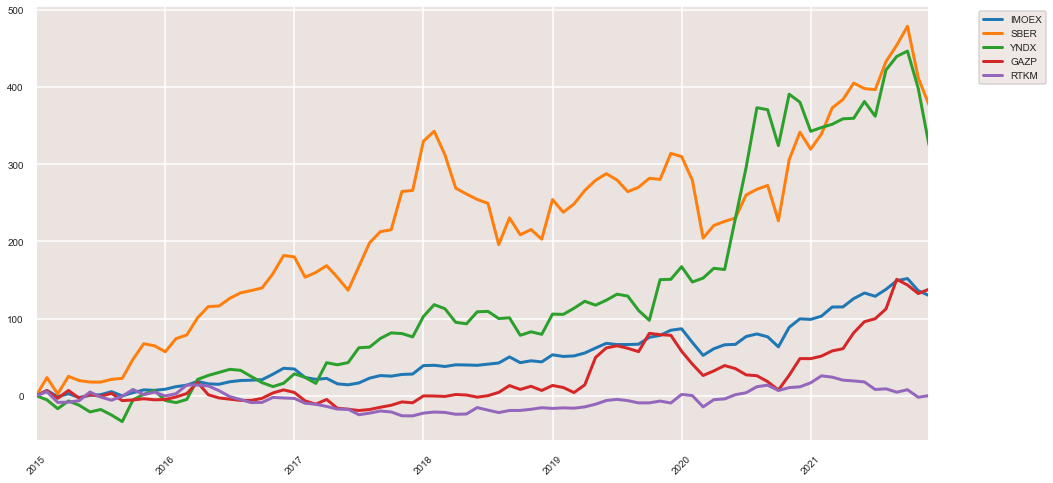

In [37]:
plot_data(df_percent_last2base[['IMOEX', 'SBER', 'YNDX', 'GAZP', 'RTKM']], fig_size=(16,8))

А теперь перейдем к шкале по каждому тикеру относительно IMOEX

In [38]:
# Переходим к отклонениям от IMOEX
df_percent_diff_last2base = df_percent_last2base.copy()
for col in df_percent_last2base.columns:
    df_percent_diff_last2base[col] = df_percent_diff_last2base[col] - df_percent_last2base['IMOEX']
df_percent_diff_last2base.drop(columns='IMOEX', inplace=True)

In [39]:
df_percent_diff_last2base.head()

,YNDX,AGRO,ALRS,VTBR,BSPB,AFKS,AFLT,GAZP,GMKN,LSRG,MVID,MAGN,MTLR,MTLRP,MTSS,MOEX,LKOH,NLMK,PIKK,PLZL,RTKM,RTKMP,SBER,SBERP,CHMF,SELG,TGKA,TRNFP,HYDR,FEES,PHOR,MSNG,NVTK,ROSN,TATN,TATNP
2015-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-02-28,-12.242070,5.186601,-19.481434,-8.117202,20.640938,30.680661,-4.296181,-0.405485,-10.440175,18.299381,12.372377,4.408172,76.679970,64.056481,7.545132,3.103445,0.103179,-18.596733,-3.959813,-0.989048,-1.684999,2.372932,16.677197,15.737178,-0.581050,10.975894,6.093525,-9.502112,16.041960,44.490783,-14.697827,10.765682,2.746302,9.160843,10.218355,0.158160
2015-03-31,-15.624769,5.768151,-6.963105,-11.662334,22.186690,35.589035,-9.805647,-2.115479,-9.125199,42.494424,39.557613,15.436726,66.968786,49.769927,14.686231,-0.123107,-1.737656,-14.325820,3.045053,-1.838890,-7.481050,4.895391,3.549366,5.388493,3.741830,13.040158,-3.555647,-10.956692,1.572080,33.541514,-10.916273,12.545774,-4.781493,11.246602,7.542740,6.378387
2015-04-30,-9.350811,33.338880,-15.334972,-7.456937,39.103791,17.262842,-2.728528,4.263545,-19.435221,27.681530,46.530044,12.653970,40.899688,35.848207,19.176242,7.532910,-7.639319,-28.245665,-1.254650,44.745868,-10.964954,2.480222,22.573560,11.584005,-12.399370,1.997195,2.625502,-16.970262,11.511200,40.045957,-13.466654,52.339111,4.924214,9.370712,5.750567,3.430183
2015-05-31,-10.128512,36.067948,-17.079882,18.742175,55.018597,29.118300,9.787585,-1.014807,-20.100949,33.122167,47.035745,14.297926,47.821554,33.954037,13.881245,5.193747,-9.441595,-18.311257,-1.142573,52.408067,-4.198438,5.444302,21.848800,12.395911,-2.948676,6.673339,20.507901,-10.665510,14.181967,32.966874,-10.321623,47.220326,15.923561,4.364074,6.056760,0.624493


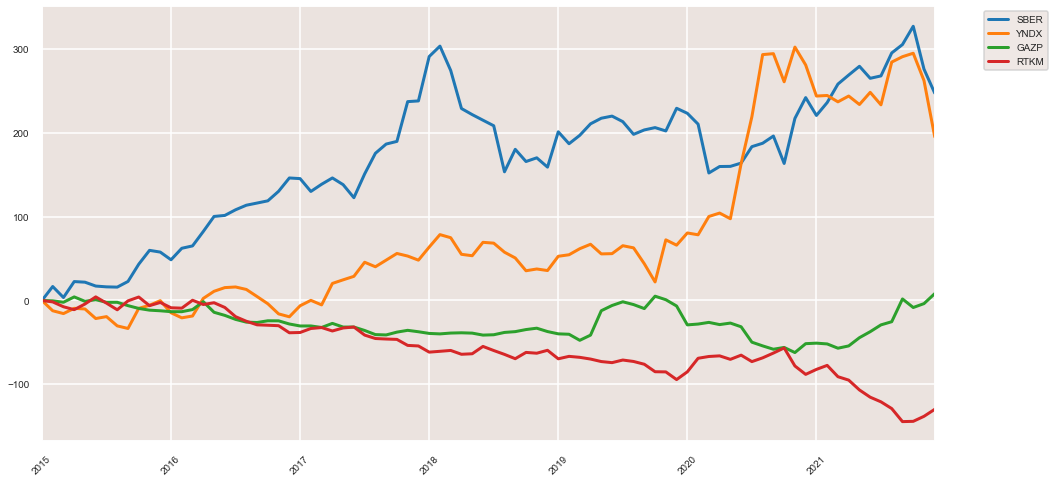

In [40]:
plot_data(df_percent_diff_last2base[['SBER', 'YNDX', 'GAZP', 'RTKM']], fig_size=(16,8))

Масштабируем каждый временной ряд

<AxesSubplot:title={'center':'После стандартизации'}>

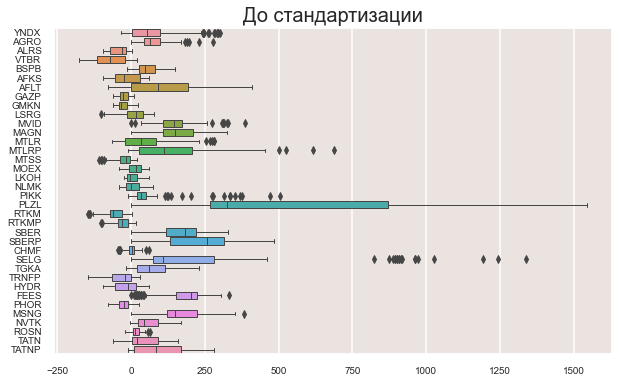

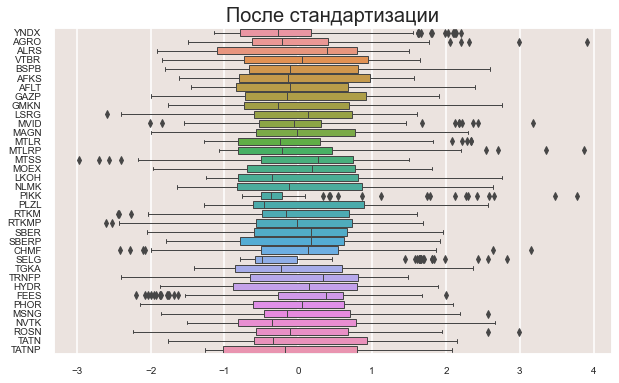

In [41]:
plt.figure(figsize=(10,6))
plt.title('До стандартизации', fontsize=20)
sns.boxplot(data=df_percent_diff_last2base, orient='h')
scaler = StandardScaler()

df_percent_diff_last2base_scaled = pd.DataFrame(scaler.fit_transform(df_percent_diff_last2base), 
                                      columns=scaler.get_feature_names_out(),
                                      index=df_percent_diff_last2base.index)

plt.figure(figsize=(10,6))
plt.title('После стандартизации', fontsize=20)
sns.boxplot(data=df_percent_diff_last2base_scaled, orient='h')

Посмотрим на результат

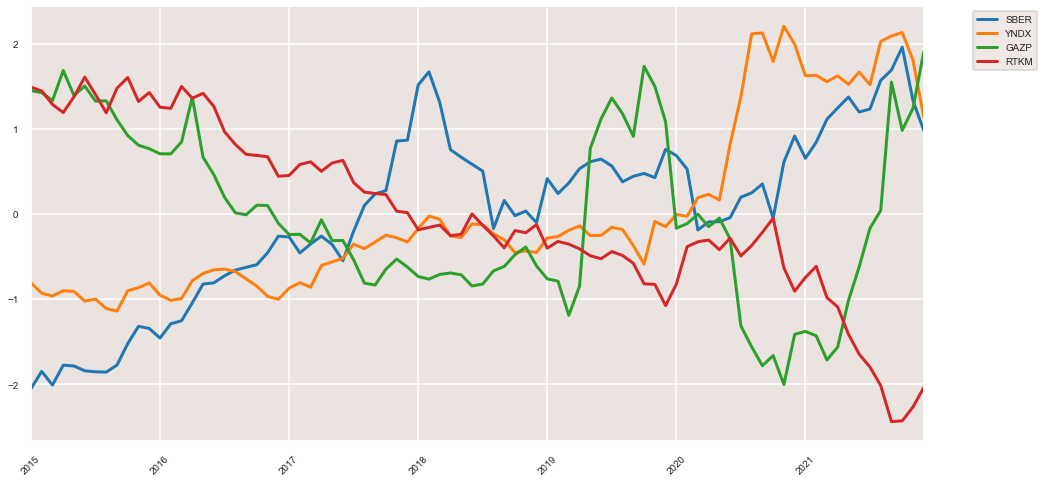

In [42]:
plot_data(df_percent_diff_last2base_scaled[['SBER', 'YNDX', 'GAZP', 'RTKM']], fig_size=(16,8))

## 3.2 K_means

Проведем класстерный анализ методом K_means. В качестве метрики расстояния будем использовать метрику 'dtw'.

Сначала воспользуемся "Методом логтя" и "Методом силуэта" анализа количества возможных кластеров в данных

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:11<00:00,  1.46s/it]


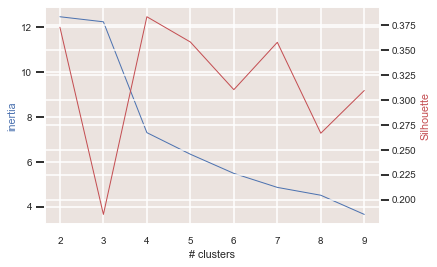

In [836]:
plot_Kmeans_explore(df_percent_diff_last2base_scaled.T, metric='dtw')

Посмотрим на устойчивость оценок при повторных инициализациях:

(36, 84, 1)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

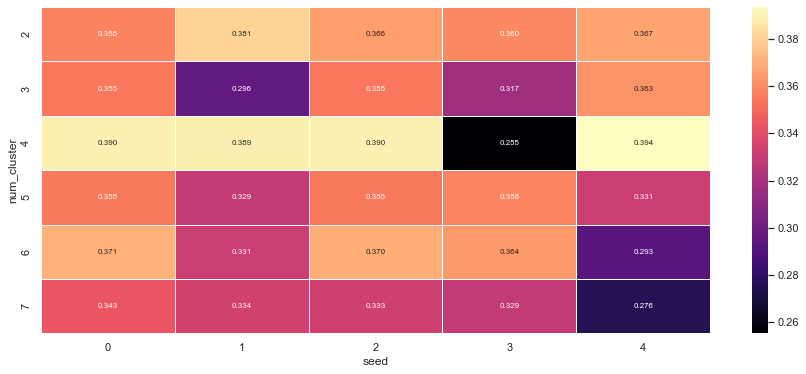

In [94]:
TimeSeriesKMeans_explorer(df_percent_diff_last2base_scaled.T, clusters_list=[2, 3,  4, 5, 6, 7], metric='dtw')

По результатам оценок можем сказать, что потенциально в данных методом K_means можем выделить 4 кластера

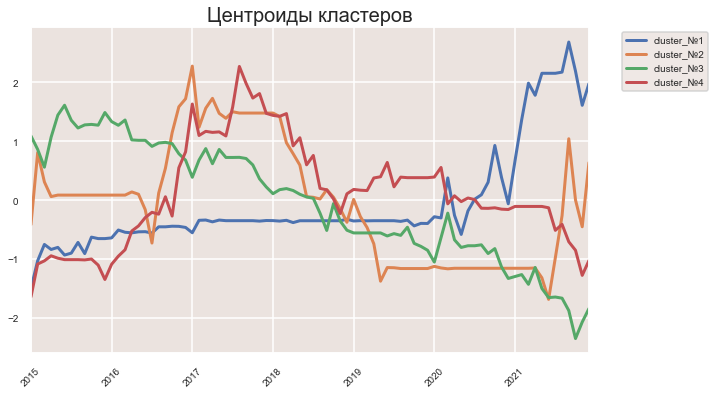

In [837]:
n_clusters = 4

df_centroids = pd.DataFrame(index = list(df_percent_diff_last2base_scaled.index), 
                columns=[f'cluster_№{i}' for i in range(1,n_clusters+1)])
                
X = to_time_series_dataset(df_percent_diff_last2base_scaled.T)
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=-1, max_iter=20)
ts_kmeans.fit(X)

for cluster_number in range(n_clusters):
    df_centroids[f'cluster_№{cluster_number+1}'] = ts_kmeans.cluster_centers_[cluster_number, :, 0]

plot_data(df_centroids, fig_size=(10,6), title='Центроиды кластеров')

df_kmeans_clusters_4 = ts_kmeans.predict(X)+1

Посмотрим на кластеры поближе:

#### ___Кластер №1

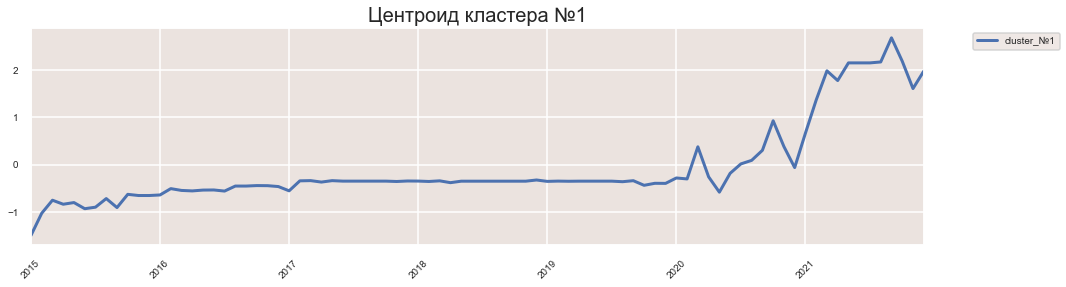

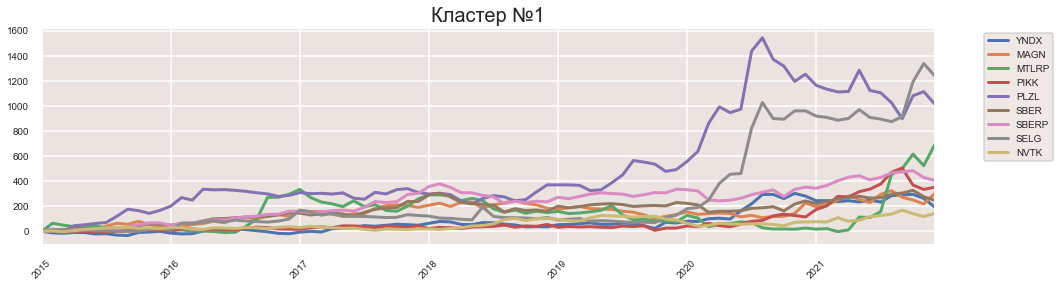

In [838]:
cluster = 1
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[df_kmeans_clusters_4==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- плавно возрастающий тренд без сильных колебаний;
- В промежутке 2015 - 2021 годов показал доходность выше индекса IMOEX

#### ___Кластер №2

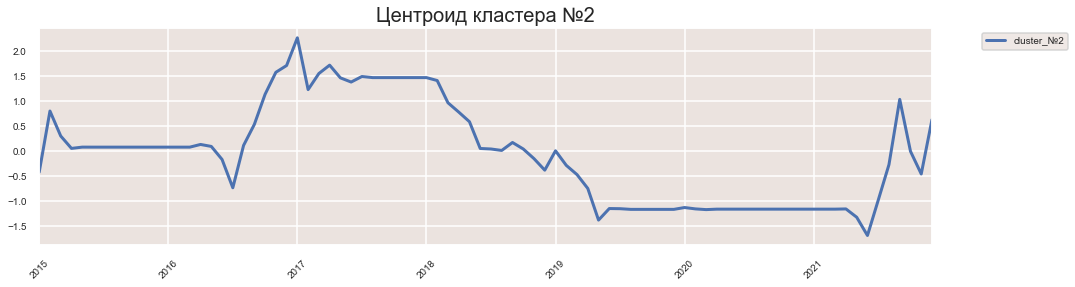

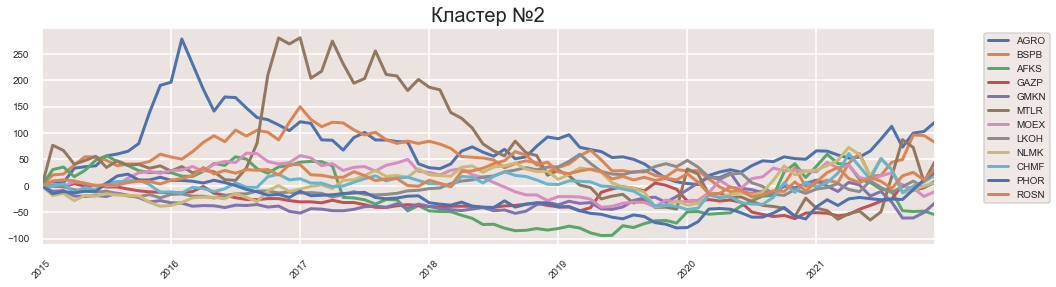

In [839]:
cluster = 2
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[df_kmeans_clusters_4==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- после 2018 года возникает восходящий тренд роста доходности относительно индекса;
- после сильного падения в "кризис" 2020-2021 годов появлятся тренд к восстановлению темпов роста доходности

#### ___Кластер №3

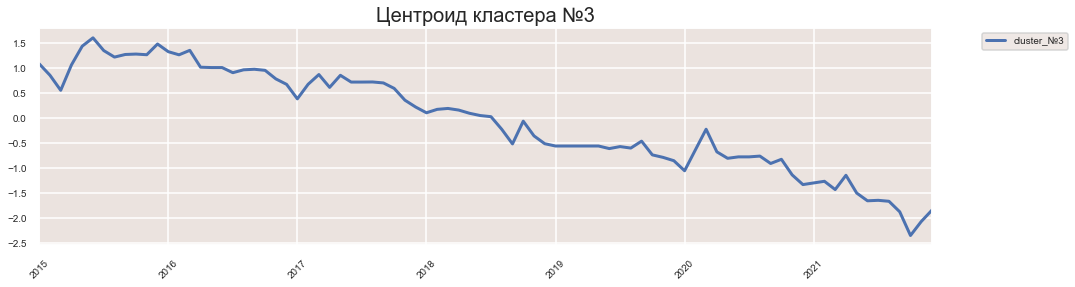

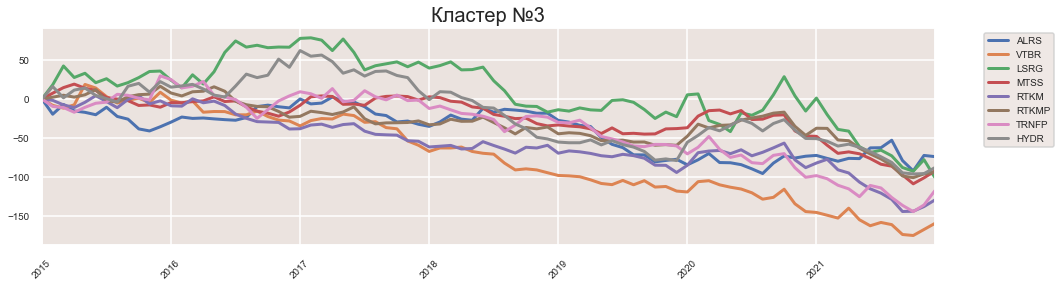

In [840]:
cluster = 3
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[df_kmeans_clusters_4==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- в первой половине временного интервала показывал доходность, сравнимую с индексом, без явного тренда к росту доходности;
- во второй половине временного интервала показывает доходность ниже индекса с явным трендом к снижению.

#### ___Кластер №4

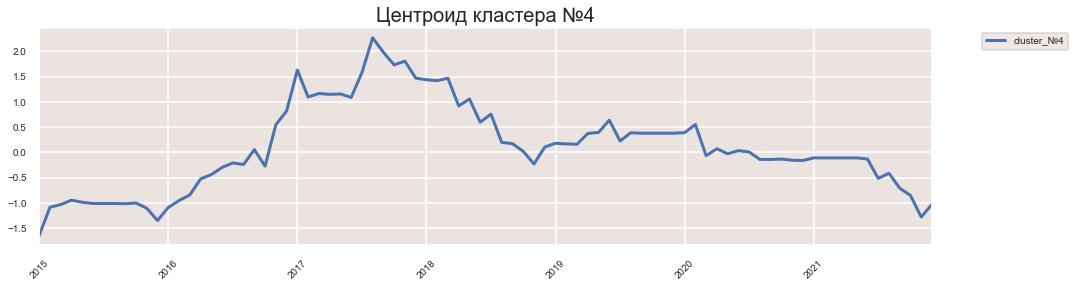

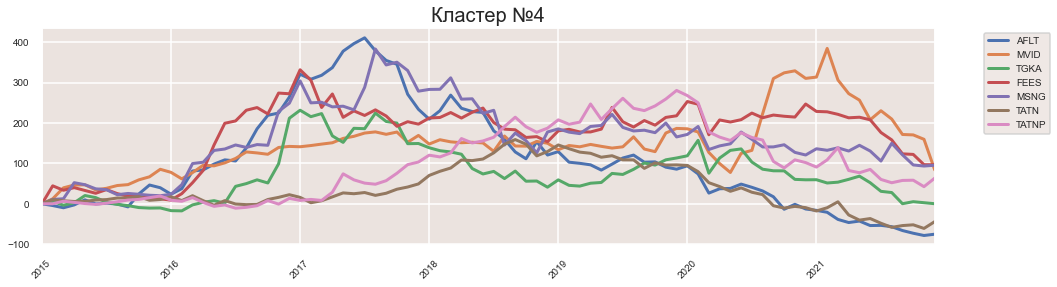

In [841]:
cluster = 4
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[df_kmeans_clusters_4==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- доходность относительно индекса колеблется около нуля, что свидетельствует о доходности, сопоставимой с доходностью индекса.

## 3.3 Иерархическая кластеризация

Попробуем другой метод кластеризации - Иерархическая кластеризации с метрикой 'dtw'.

Сначала проанализируем количество возможных кластеров в данных.

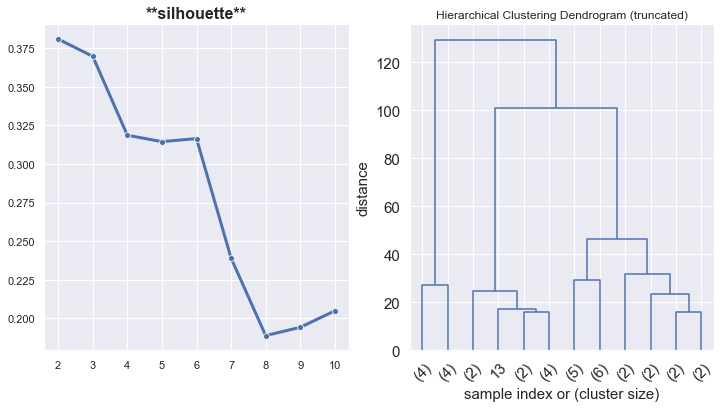

In [152]:
hierarchy_clustering_explorer (df_percent_diff_last2base_scaled.T, metric='dtw', MAX_CLUSTERS=10)

По результатам оценок можем сказать, что потенциально в данных методом K_means можем выделить 3 кластера

Распределение кластеров:


,clusters %
0,52.777778
1,25.000000
2,22.222222


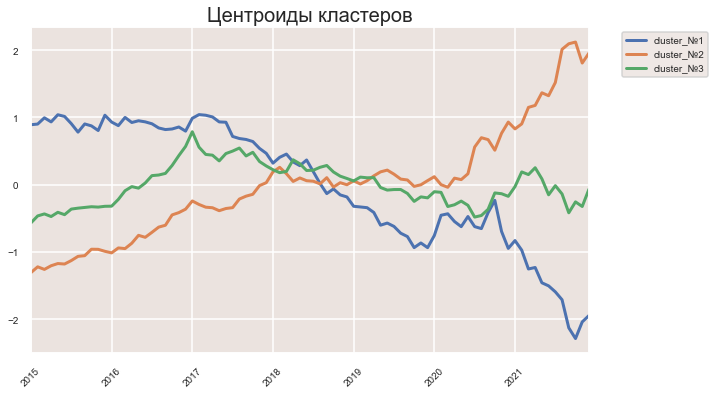

In [785]:
clusters_df, df_centroids = get_hierarchy_clusters(df_percent_diff_last2base_scaled.T, metric='dtw',clusters_count=3, centroids=True)

#### ___Кластер №1

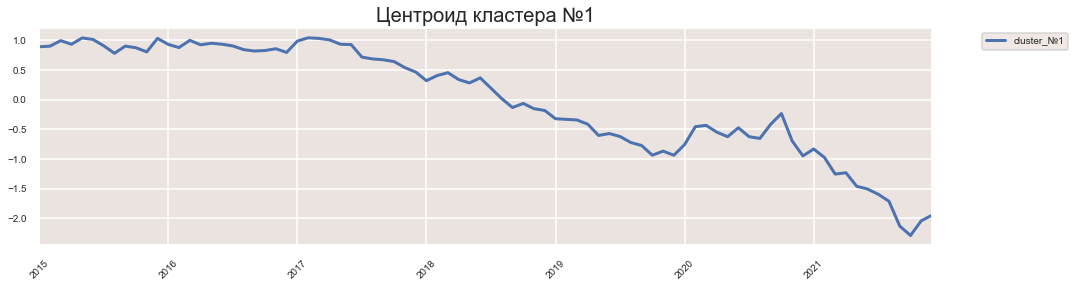

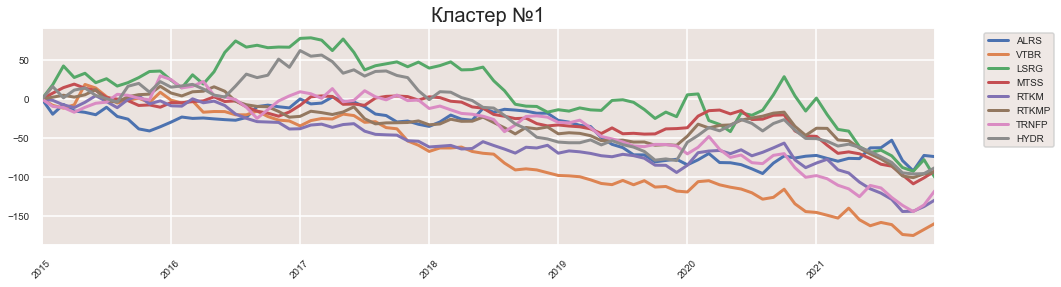

In [786]:
cluster = 1
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[clusters_df['cluster']==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- в первой половине временного интервала показывал доходность, сравнимую с индексом, без явного тренда к росту доходности;
- во второй половине временного интервала показывает доходность ниже индекса с явным трендом к снижению.

#### ___Кластер №2

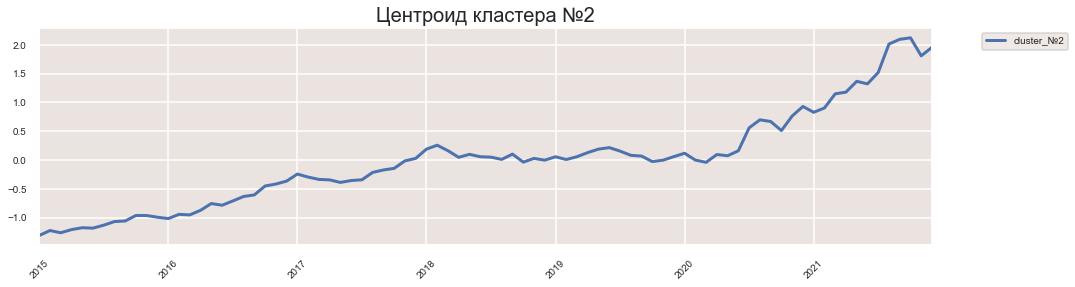

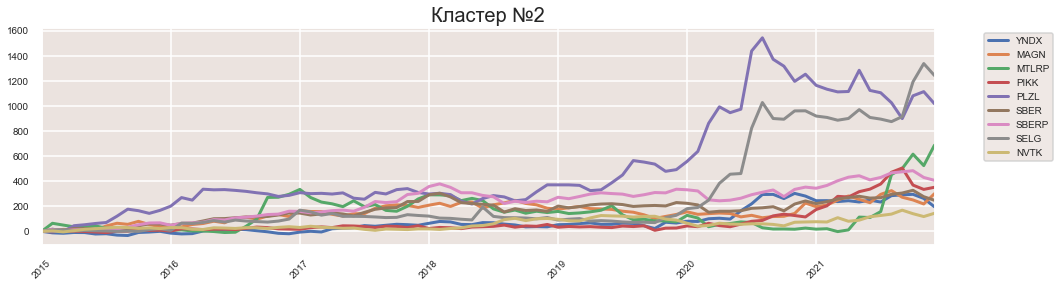

In [787]:
cluster = 2
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[clusters_df['cluster']==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- плавно возрастающий тренд без сильных колебаний;
- В промежутке 2015 - 2021 годов показал доходность выше индекса IMOEX

#### ___Кластер №3

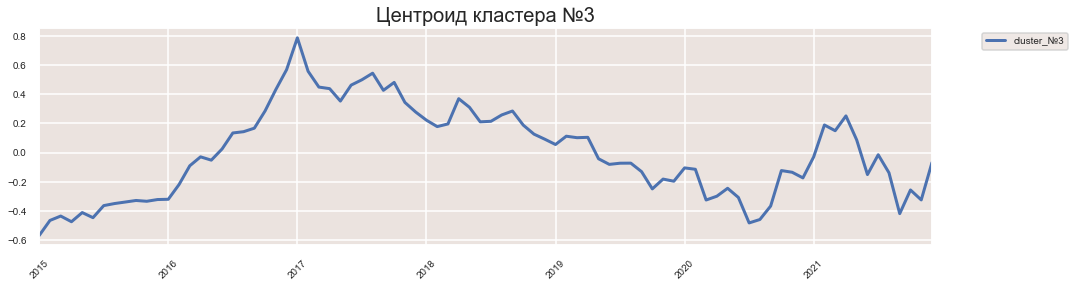

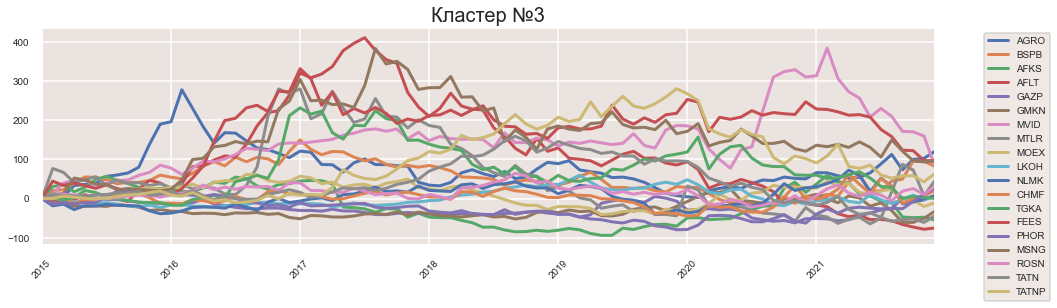

In [788]:
cluster = 3
plot_data(df_centroids[f'cluster_№{cluster}'], title=f'Центроид кластера №{cluster}')
plot_data(df_percent_diff_last2base.T[clusters_df['cluster']==cluster].T, title=f'Кластер №{cluster}')

Характерный представитель кластера: 
- в среднем за весь период доходность относительно индекса колеблется около нуля, что свидетельствует о доходности, сопоставимой с доходностью индекса.